In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import datetime
import warnings
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
warnings.filterwarnings('ignore')

# 1) Sarima Model Optimization

## 1.1) Cleaning the Data

### Saving clean DF

In [42]:
#model_df.to_csv('../data/prices_scores_clean.csv')

In [43]:
#prices_greed_df = pd.merge(prices_df,greed_df,on='date')
#prices_greed_df = prices_greed_df.set_index('date')
#prices_greed_df.to_csv('../data/prices_greed_score_clean.csv')

### Retrieving DF from folder

In [44]:
augmento_df = pd.read_csv('../data/prices_scores_clean.csv')
augmento_df.columns = ['date', 'price', 'BTC_score','twitter_score','reddit_score']
augmento_df['date'] = pd.to_datetime(augmento_df['date'])
augmento_df.columns = ['ds','y','BTC_score', 'twitter_score','reddit_score']
#model_df = model_df.set_index('date')

In [45]:
prices_greed_df = pd.read_csv('../data/prices_greed_score_clean.csv')
#prices_greed_df = prices_greed_df.set_index('date')
prices_greed_df.columns=['date','price','score']
prices_greed_df['date'] = pd.to_datetime(prices_greed_df['date'])
prices_greed_df.columns = ['ds','y','score']

In [46]:
full_df = pd.merge(prices_greed_df, augmento_df, on='ds')

In [47]:
full_df = full_df.drop_duplicates()
full_df = full_df.reset_index()
full_df = full_df[['ds','y_x','score','BTC_score', 'twitter_score','reddit_score']]
full_df.columns = ['ds','y','score','BTC_score', 'twitter_score','reddit_score']

# 2) Facebook Profit (Final Model to deploy)

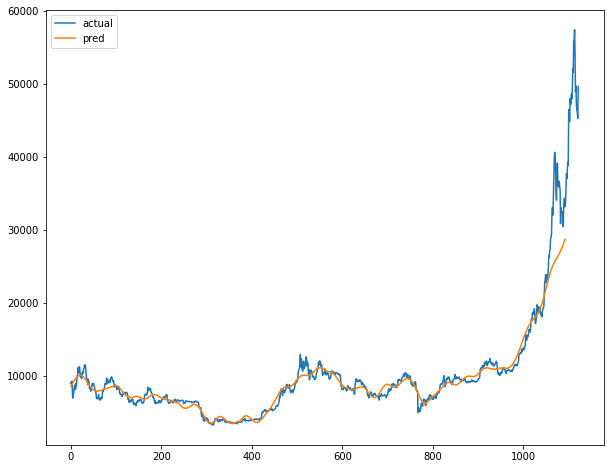

In [14]:
plt.figure(figsize=(10,8))
plt.plot(prices_greed_df["y"], label="actual")
plt.plot(forecast["yhat"], label="pred")
plt.legend()

In [16]:
horizon = 30
fg_model_future = fg_model.make_future_dataframe(horizon)
fg_model_future["score"] = prices_greed_df["score"] 
fg_forecast = fg_model.predict(fg_model_future)

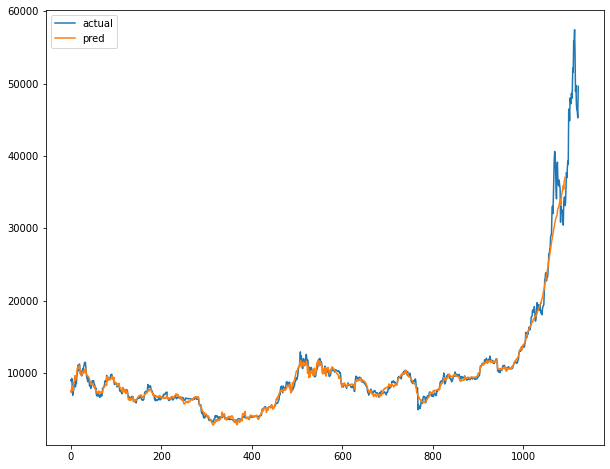

In [17]:
plt.figure(figsize=(10,8))
plt.plot(prices_greed_df["y"], label="actual")
plt.plot(fg_forecast["yhat"], label="pred")
plt.legend()

## Generating predictions DataFrame without scores

In [49]:
start_index_1=500

In [27]:
predictions = {}
for index in range(start_index_1, 1122):
    model = Prophet(interval_width=0.95, weekly_seasonality=True, changepoint_prior_scale=2)
    model.fit(prices_greed_df[:index])
    horizon = 1
    model_future = model.make_future_dataframe(horizon) 
    forecast = model.predict(model_future)
    predictions[forecast['ds'][index]] = forecast['yhat'][index]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [28]:
real_preds = {}
for key, value in predictions.items():
    real_preds[key.strftime('%Y-%m-%d')] = [value]

In [29]:
actuals = prices_greed_df[start_index_1:][['ds','y']]

In [30]:
real_preds = pd.DataFrame(real_preds)
real_preds = real_preds.T
real_preds = real_preds.reset_index()
real_preds.columns = ['ds','pred']
real_preds.ds = pd.to_datetime(real_preds.ds)

In [31]:
comparision = pd.merge(actuals,real_preds, on='ds', how='left')
comparision['mae'] = abs(comparision['y'] - comparision['pred'])
comparision['actual_change'] = comparision['y']-comparision.shift(1)['y']
comparision['pred_change'] = comparision['pred']-comparision.shift(1)['y']
comparision['actual_change'] = np.where(comparision['actual_change']>0,1,0)
comparision['pred_change'] = np.where(comparision['pred_change']>0,1,0)
comparision['correct_pred'] = np.where(comparision['pred_change']==comparision['actual_change'], 1, 0)

In [32]:
comparision['correct_pred'].sum()/len(comparision['correct_pred'])

0.4983922829581994

In [33]:
comparision['mae'].mean()

1096.1259608467442

In [34]:
comparision['previous_price'] = comparision.shift(1)['y']
comparision['previous_pred_change'] = comparision.shift(1)['pred_change']

In [35]:
comparision['future_change'] = comparision.shift(-1)['pred_change']

## Generating predictions DataFrame with scores

In [50]:
start_index = 500

In [46]:
predictions_2 = {}
for index in range(start_index, 1122):
    model = Prophet(interval_width=0.9, weekly_seasonality=True, changepoint_prior_scale=0.5)
    model.add_regressor("score")
    model.fit(prices_greed_df[:index])
    horizon = 1
    model_future = model.make_future_dataframe(horizon)
    model_future["score"] = prices_greed_df["score"] 
    forecast = model.predict(model_future)
    predictions_2[forecast['ds'][index]] = forecast['yhat'][index]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [47]:
real_preds_2 = {}
for key, value in predictions_2.items():
    real_preds_2[key.strftime('%Y-%m-%d')] = [value]

In [48]:
actuals_2 = prices_greed_df[start_index:][['ds','y']]

In [49]:
real_preds_2 = pd.DataFrame(real_preds_2)
real_preds_2 = real_preds_2.T
real_preds_2 = real_preds_2.reset_index()
real_preds_2.columns = ['ds','pred']
real_preds_2.ds = pd.to_datetime(real_preds_2.ds)

In [50]:
comparision_2 = pd.merge(actuals_2,real_preds_2, on='ds', how='left')

In [51]:
comparision_2['mae'] = abs(comparision_2['y'] - comparision_2['pred'])

In [52]:
comparision_2['actual_change'] = comparision_2['y']-comparision_2.shift(1)['y']
comparision_2['pred_change'] = comparision_2['pred']-comparision_2.shift(1)['y']

In [53]:
comparision_2['actual_change'] = np.where(comparision_2['actual_change']>0,1,0)
comparision_2['pred_change'] = np.where(comparision_2['pred_change']>0,1,0)

In [54]:
comparision_2['correct_pred'] = np.where(comparision_2['pred_change']==comparision_2['actual_change'], 1, 0)

In [55]:
comparision_2['correct_pred'].sum()/len(comparision_2['correct_pred'])

0.5353697749196141

In [56]:
comparision_2['mae'].mean()

974.9540944091292

In [57]:
comparision_2['previous_price'] = comparision_2.shift(1)['y']

In [58]:
comparision_2['previous_pred_change'] = comparision_2.shift(1)['pred_change']

In [59]:
comparision_2['future_change'] = comparision_2.shift(-1)['pred_change']

## Generating predictions DataFrame with ALL scores

In [51]:
predictions_3 = {}
for index in range(start_index, 1092):
    model = Prophet(interval_width=0.9, weekly_seasonality=True, changepoint_prior_scale=0.5)
    model.add_regressor("score")
    model.add_regressor("BTC_score")
    model.add_regressor("twitter_score")
    model.add_regressor("reddit_score")
    model.fit(full_df[:index])
    horizon = 1
    model_future = model.make_future_dataframe(horizon)
    model_future["score"] = full_df["score"] 
    model_future["BTC_score"] = full_df["BTC_score"] 
    model_future["twitter_score"] = full_df["twitter_score"] 
    model_future["reddit_score"] = full_df["reddit_score"] 
    forecast = model.predict(model_future)
    predictions_3[forecast['ds'][index]] = forecast['yhat'][index]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [52]:
real_preds_3 = {}
for key, value in predictions_3.items():
    real_preds_3[key.strftime('%Y-%m-%d')] = [value]

In [53]:
actuals_3 = full_df[start_index_1:][['ds','y']]

In [54]:
real_preds_3 = pd.DataFrame(real_preds_3)
real_preds_3 = real_preds_3.T
real_preds_3 = real_preds_3.reset_index()
real_preds_3.columns = ['ds','pred']
real_preds_3.ds = pd.to_datetime(real_preds_3.ds)

In [55]:
comparision_3 = pd.merge(actuals_3,real_preds_3, on='ds', how='left')
comparision_3['mae'] = abs(comparision_3['y'] - comparision_3['pred'])
comparision_3['actual_change'] = comparision_3['y']-comparision_3.shift(1)['y']
comparision_3['pred_change'] = comparision_3['pred']-comparision_3.shift(1)['y']
comparision_3['actual_change'] = np.where(comparision_3['actual_change']>0,1,0)
comparision_3['pred_change'] = np.where(comparision_3['pred_change']>0,1,0)
comparision_3['correct_pred'] = np.where(comparision_3['pred_change']==comparision_3['actual_change'], 1, 0)

In [56]:
comparision_3['previous_price'] = comparision_3.shift(1)['y']
comparision_3['previous_pred_change'] = comparision_3.shift(1)['pred_change']

In [57]:
comparision_3['future_change'] = comparision_3.shift(-1)['pred_change']

In [58]:
comparision_3['correct_pred'].sum()/len(comparision_3['correct_pred'])

0.5767284991568297

In [59]:
comparision_3['mae'].mean()

819.8181101119519

In [90]:
comparision_3

,ds,y,pred,mae,actual_change,pred_change,correct_pred,previous_price,previous_pred_change,future_change
0,2019-06-19,9288.5367,9388.198529,99.661829,0,0,1,NaN,NaN,1.0
1,2019-06-20,9539.7883,9457.301208,82.487092,1,1,1,9288.5367,0.0,1.0
2,2019-06-21,10232.9167,9761.397807,471.518893,1,1,1,9539.7883,1.0,0.0
3,2019-06-22,10695.3683,9673.435933,1021.932367,1,0,0,10232.9167,1.0,0.0
4,2019-06-23,10860.8233,9740.600738,1120.222562,1,0,0,10695.3683,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
588,2021-01-27,30425.3933,36955.929637,6530.536337,0,1,0,32518.3583,1.0,1.0
589,2021-01-28,33420.0450,35485.426308,2065.381308,1,1,1,30425.3933,1.0,1.0
590,2021-01-29,34264.0100,36293.677185,2029.667185,1,1,1,33420.0450,1.0,1.0
591,2021-01-30,34324.2717,35924.770184,1600.498484,1,1,1,34264.0100,1.0,0.0


## Testing Wallet

In [152]:
def wallet(budget, df, start='2019-06-19', end='2021-03-01'):
    start = df[df['ds']==start].index[0]
    end = df[df['ds']==end].index[0]
    new_df = df[start:end]
    
    cash = budget
    btc_value = 0
    
    portfolio_value = []
    transaction_dates = []
    for index, row in new_df.iterrows():
        
        if row['future_change']==1:   
            if cash==0:
                #transaction_dates.append(row['ds'])
                #portfolio_value.append(portfolio_value[-1])
                pass
            else:
                btc_value = (cash/row['y'])

                transaction_dates.append(row['ds'])
        
                
                portfolio_value.append(cash)
                cash = 0
                
                
        if row['future_change']==0 and btc_value>0: 
            cash = btc_value*row['y']
            btc_value = 0
            portfolio_value.append(cash)
            transaction_dates.append(row['ds'])

        #else:
            #transaction_dates.append(row['ds'])
            #portfolio_value.append(cash)
        
    if cash == 0: 
        portfolio = btc_value*df[end:]['y'][end]
        return (portfolio, portfolio_value, transaction_dates)
    else:       
        return (cash, portfolio_value, transaction_dates)

In [215]:
def wallet_2(budget, df, start='2019-06-19', end='2021-03-01'):
    start = df[df['ds']==start].index[0]
    end = df[df['ds']==end].index[0]
    new_df = df[start:end]
    
    cash = budget
    btc_value = 0
    
    portfolio_value = []
    transaction_dates = []
    for index, row in new_df.iterrows():
        
        if row['future_change']==1:   
            if cash==0:
                transaction_dates.append(row['ds'])
                portfolio_value.append(portfolio_value[-1])
            
            else:
                btc_value = (cash/row['y'])

                transaction_dates.append(row['ds'])
        
                
                portfolio_value.append(cash)
                cash = 0
                
                
        if row['future_change']==0:
            if len(portfolio_value)==0:
                portfolio_value.append(budget)
                transaction_dates.append(row['ds'])
            else:
                transaction_dates.append(row['ds'])
                portfolio_value.append(portfolio_value[-1])
                if btc_value>0:
                    cash = btc_value*row['y']
                    btc_value = 0
                #portfolio_value.append(cash)
                #transaction_dates.append(row['ds'])

        #else:
            #transaction_dates.append(row['ds'])
            #portfolio_value.append(cash)
        
    if cash == 0: 
        portfolio = btc_value*df[end:]['y'][end]
        return (portfolio, portfolio_value, transaction_dates)
    else:       
        return (cash, portfolio_value, transaction_dates)

In [197]:
#comparision_2 = pd.read_csv('../data/predictions_fear_greed_score.csv')

In [203]:
#comparision = pd.read_csv('../data/predictions_no_score.csv')
comparision_3 = pd.read_csv('../data/predictions_all_scores_best.csv')

In [216]:
(wallet_2(100, comparision_3, end='2021-01-31')[2][-1])

'2021-01-30'

In [221]:
datemin = np.datetime64(wallet_2(100,comparision_3, end='2021-01-31')[2][0], 'M')
datemax = np.datetime64(wallet_2(100,comparision_3, end='2021-01-31')[2][-1], 'M') + np.timedelta64(1, 'M')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

<AxesSubplot:>

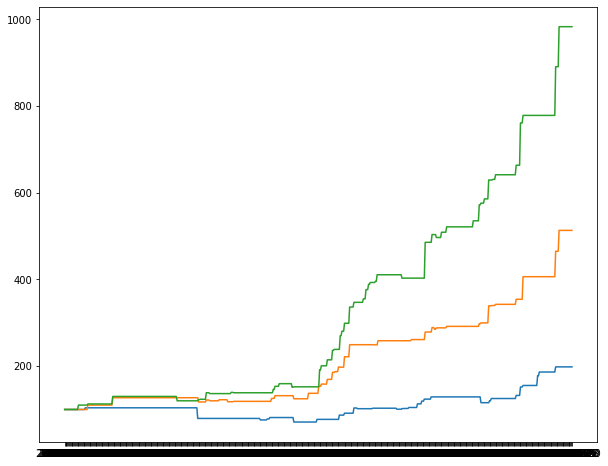

In [249]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
sns.lineplot(wallet_2(100, comparision, end='2021-01-31')[2],wallet_2(100, comparision, end='2021-01-31')[1])
sns.lineplot(wallet_2(100, comparision_2, end='2021-01-31')[2],wallet_2(100, comparision_2, end='2021-01-31')[1])
sns.lineplot(wallet_2(100,comparision_3, end='2021-01-31')[2],wallet_2(100,comparision_3, end='2021-01-31')[1])

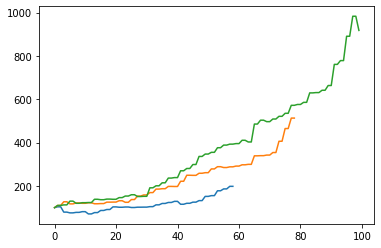

In [126]:
plt.plot(wallet(100, comparision, end='2021-01-31')[1])
plt.plot(wallet(100, comparision_2, end='2021-01-31')[1])
plt.plot(wallet(100,comparision_3, end='2021-01-31')[1])
plt.show()

In [161]:
#comparision_2.to_csv('../data/predictions_fear_greed_score.csv')

In [164]:
#comparision.to_csv('../data/predictions_no_score.csv')

In [80]:
#comparision_3.to_csv('../data/predictions_all_scores_best.csv')

## Plotting

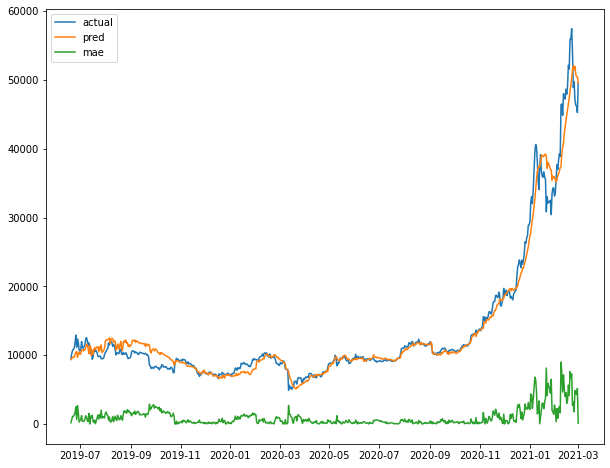

In [139]:
plt.figure(figsize=(10,8))
plt.plot(comparision_2[1:]['ds'],comparision_2[1:]['y'], label='actual')
plt.plot(comparision_2[1:]['ds'],comparision_2[1:]['pred'], label='pred')
plt.plot(comparision_2[1:]['ds'],comparision_2[1:]['mae'], label='mae')
plt.legend()
plt.show()

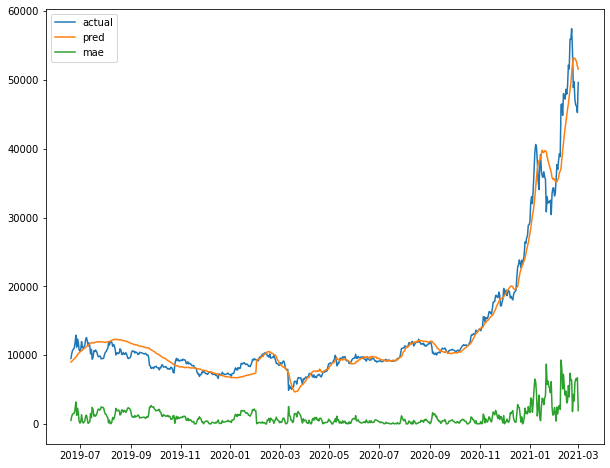

In [140]:
plt.figure(figsize=(10,8))
plt.plot(comparision[1:]['ds'],comparision[1:]['y'], label='actual')
plt.plot(comparision[1:]['ds'],comparision[1:]['pred'], label='pred')
plt.plot(comparision[1:]['ds'],comparision[1:]['mae'], label='mae')
plt.legend()
plt.show()